## Target configuration

In [30]:
import logging
from conf import LisaLogging
LisaLogging.setup()#level=logging.WARNING)

2018-01-15 14:41:12,151 INFO    : root         : Using LISA logging configuration:
2018-01-15 14:41:12,153 INFO    : root         :   /home/leoy/Work/tools/lisa-ml-20171106/logging.conf


In [31]:
%matplotlib inline

import os
import json

import devlib
from env import TestEnv

import trappy
# Support for trace events analysis
from trace import Trace

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from wlgen import RTA, Periodic, Ramp

In [32]:
res_dir = '/home/leoy/Work/tools/lisa-ml-20171106/results/wltests/wa.08ec46d_08ec46d/wk1-exoplayer-3/'
trace_file = os.path.join(res_dir, "trace.dat")

In [33]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"     : 'android',
    "board"        : 'hikey960',
    
    # Device serial ID
    # Not required if there is only one device connected to your computer
    "device"       : "270182BA020B1AA2",
    
    "ANDROID_HOME" : "/home/leoy/Work/tools/lisa-mainline/tools/android-sdk-linux",
    
    # Energy Meters Configuration for BayLibre's ACME Cape
    "emeter" : {
        "instrument" : "aep",
        "conf" : {
            'resistor_values' : [0.033],
            'device_entry'    : '/dev/ttyACM0'
        },
        "channel_map" : {
            "Device0" : "BAT"
        }
    },

    # Folder where all the results will be collected
    "results_dir" : "taskset_test",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq',
        'cpuidle'
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_sugov_util",
            "sched_load_avg_cpu",
            "sched_boost_cpu",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset', 'rt-app', 'sysbench'],
}

In [34]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            903000,
            1421000,
            1805000,
            2112000,
            2362000
        ],
        'little': [
            533000,
            999000,
            1402000,
            1709000,
            1844000]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 559
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 4269
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 181
            },
            'cpu': {
                'cap_max': 466,
                'nrg_max': 731
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

In [35]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True, window=(5, 25))

{0: 1.7588401868458854,
 1: 1.7586913155743793,
 2: 1.7586674767872921,
 3: 1.7586524184766466,
 4: 2.1448208266070123,
 5: 2.1448121344946323,
 6: 2.1448061503148632,
 7: 2.1448024402652912}

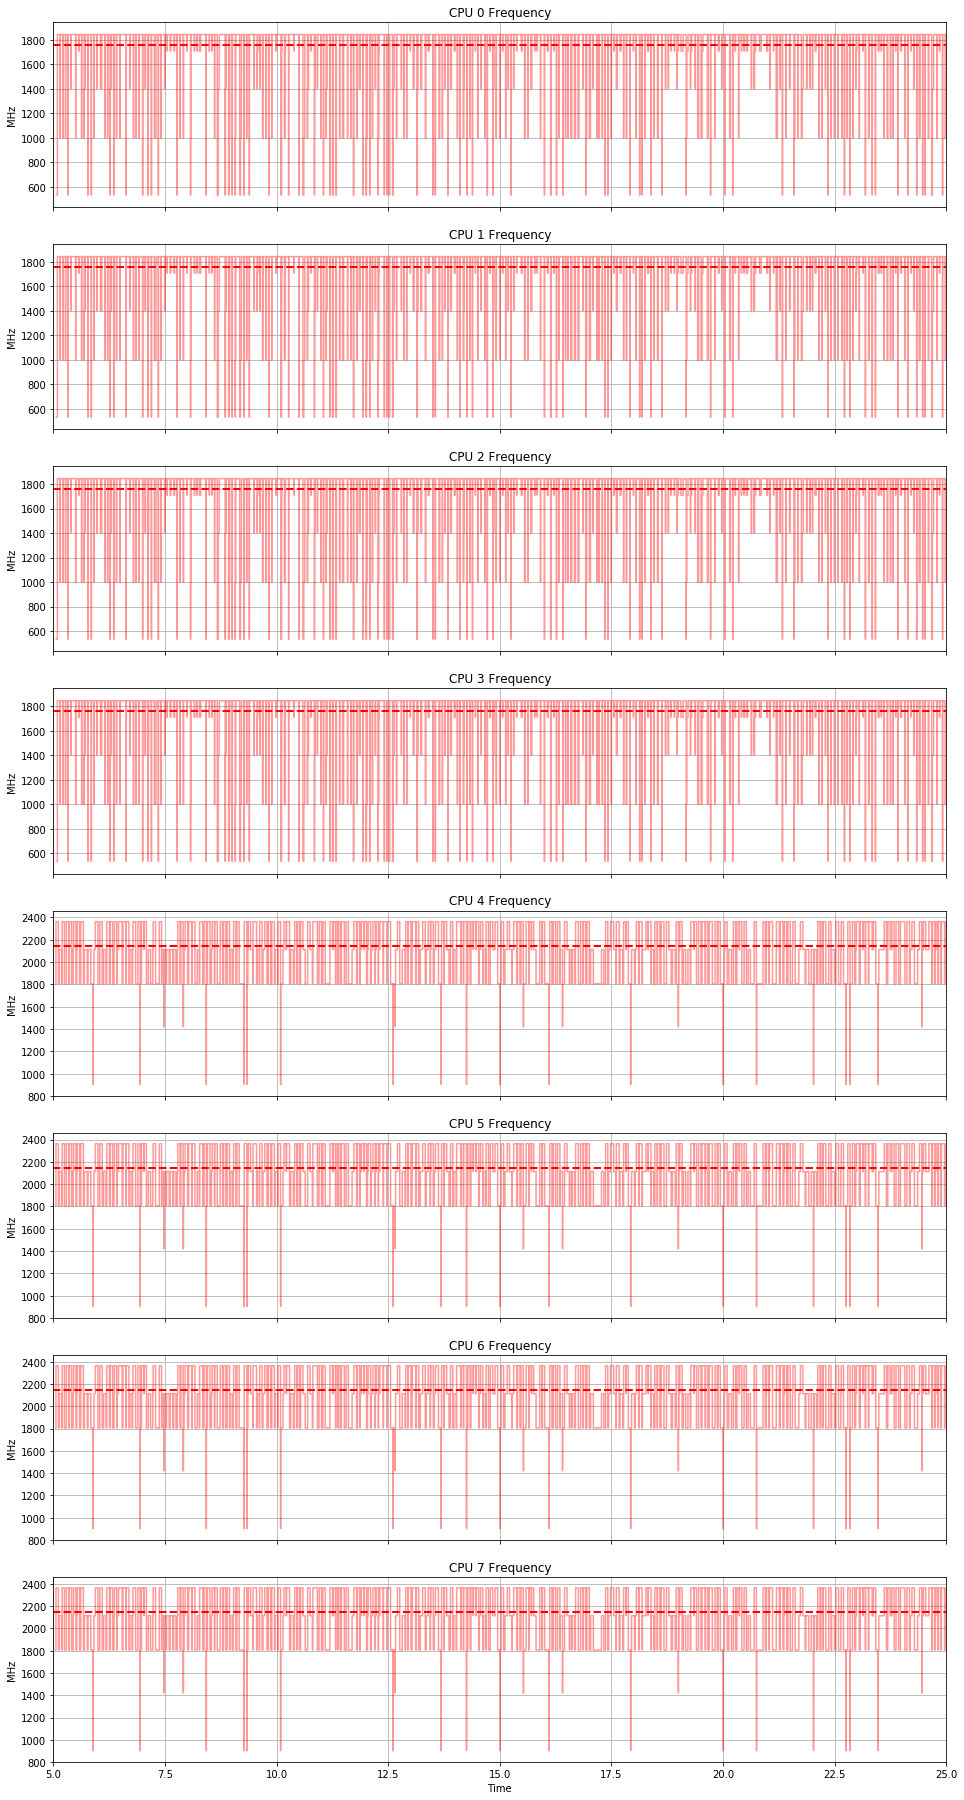

In [36]:
trace.analysis.frequency.plotCPUFrequencies()

In [37]:
data_frame_cpu_util = trace.data_frame.trace_event('sched_sugov_util')

In [38]:
#
# 
def analysis_cpu_util(cls):

    df = trace.data_frame.trace_event('sched_sugov_util')
    
    if df.empty:
        return
    
    for cluster,cpus in platform['clusters'].iteritems():
        if cluster != cls:
            continue
            
        cpu_util_mean_df = pd.DataFrame(
            {
                'rt_util': [df[df.cpu == cpu]['rt_util'].mean() for cpu in cpus],
                'cfs_util': [df[df.cpu == cpu]['cfs_util'].mean() for cpu in cpus],
                'total_util': [df[df.cpu == cpu]['total_util'].mean() for cpu in cpus],
            },
            index=cpus,
        )

        std = cpu_util_mean_df.std()
        cpu_util_mean_df.loc['stdd'] = std
        
        return cpu_util_mean_df

In [39]:
analysis_cpu_util('little')

,cfs_util,rt_util,total_util
0,188.112002,27.006441,215.118444
1,150.963016,4.813929,155.776945
2,159.516660,1.302537,160.819197
3,150.673158,0.342371,151.015529
stdd,17.679706,12.574503,29.893161


In [40]:
analysis_cpu_util('big')

,cfs_util,rt_util,total_util
4,319.158997,2.000000,321.158997
5,390.936362,0.981928,391.918291
6,360.211620,0.000000,360.211620
7,295.363757,0.000000,295.363757
stdd,42.511665,0.955896,42.554588
